In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pydrake
from pydrake.all import (
    DiagramBuilder,
    MonteCarloSimulation,
    PiecewisePolynomial,
    Simulator,
    RandomGenerator
)
import time
import matplotlib.pyplot as plt

import scene_generation.data.dataset_utils as dataset_utils

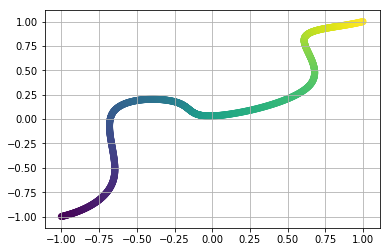

In [2]:
# For the tabletop dataset, rig up a simple task (for which it is still
# nontrivial to estimate performance): given the environment, can a point
# robot follow a fixed path from point A to point B?

# Make an interesting trajectory from ptA to ptB by randomly perturbing the
# linear interpolation.
np.random.seed(43)
ptA = np.array([[-1, -1.]]).T
intermed_pts_offsets = np.random.randn(2, 6)*0.25
ptB = np.array([[1., 1.]]).T
ptsX = np.linspace(ptA[0], ptB[0], 2 + intermed_pts_offsets.shape[1])
ptsX[1:-1] += intermed_pts_offsets[0, :]
ptsY = np.linspace(ptA[1], ptB[1], 2 + intermed_pts_offsets.shape[1])
ptsY[1:-1] += intermed_pts_offsets[1, :]
ts = np.linspace(0, 1, 2 + intermed_pts_offsets.shape[1])
pts = np.vstack([ptsX, ptsY])
path = PiecewisePolynomial.Cubic(ts, pts, True)

t_samples = np.linspace(0, 1, 1000)
pt_samples = np.stack([path.value(t) for t in t_samples])
plt.scatter(pt_samples[:, 0].ravel(), pt_samples[:, 1].ravel(), c=t_samples.ravel())
plt.grid(True)

In [3]:
# Load a big set of example environments
DATA_DIR_TRAIN = "/home/gizatt/projects/scene_generation/data/planar_tabletop/planar_tabletop_lines_scenes_train/"
DATA_DIR_TEST = "/home/gizatt/projects/scene_generation/data/planar_tabletop/planar_tabletop_lines_scenes_test/"

DATA_DIR_GENERATED_WITH_PROJ_WITH_CONTEXT = "/home/gizatt/projects/scene_generation/notebooks/planar_tabletop/generated_tabletop_lines_scenes_with_context_and_projection.yaml"
DATA_DIR_GENERATED_WITHOUT_PROJ_WITH_CONTEXT = "/home/gizatt/projects/scene_generation/notebooks/planar_tabletop/generated_tabletop_lines_scenes_with_context_without_projection.yaml"
DATA_DIR_GENERATED_WITHOUT_PROJ_WITHOUT_CONTEXT = "/home/gizatt/projects/scene_generation/notebooks/planar_tabletop/generated_tabletop_lines_scenes_without_context_without_projection.yaml"
DATA_DIR_GENERATED_WITH_PROJ_WITHOUT_CONTEXT = "/home/gizatt/projects/scene_generation/notebooks/planar_tabletop/generated_tabletop_lines_scenes_without_context_with_projection.yaml"
scenes_dataset_yaml = dataset_utils.ScenesDataset(DATA_DIR_TEST)

In [5]:
all_diagrams = []
def make_simulator(generator):
    ''' Returns a Simulator deterministically given this
    generator. '''
    # Sample an environment + build the appropriate MBP.
    dataset_ind = generator() % len(scenes_dataset_yaml)
    builder, mbp, sg, q0 = dataset_utils.BuildMbpAndSgFromYamlEnvironment(
        scenes_dataset_yaml[dataset_ind], base_environment_type="planar_tabletop",
        timestep=0.01)
    mbp.set_name("mbp")
    sg.set_name("sg")
    diagram = builder.Build()
    global all_diagrams
    all_diagrams.append(diagram)
    simulator = Simulator(diagram)
    simulator.Initialize()
    return simulator

def calc_error(diagram, context):
    mbp = diagram.GetSubsystemByName("mbp")
    sg = diagram.GetSubsystemByName("sg")
    mbp_context = diagram.GetSubsystemContext(mbp, context)
    sg_context = diagram.GetMutableSubsystemContext(sg, context)
    query_object = sg.get_query_output_port().Eval(sg_context)

    total_min_dist = np.inf
    for t in t_samples:
        dists = query_object.ComputeSignedDistanceToPoint(
                 np.vstack([path.value(t), [0]]))
        min_dist = min([d.distance for d in dists])
        total_min_dist = min(min_dist, total_min_dist)
    return total_min_dist

results = MonteCarloSimulation(
    make_simulator=make_simulator, output=calc_error,
    final_time=1.0, num_samples=10, generator=RandomGenerator())

binary_results = np.array([abs(res.output) < 0.05 for res in results])
passing_ratio = float(sum(binary_results)) / len(results)
# 95% confidence interval for the passing ratio.
passing_ratio_var = 1.96 * np.sqrt(
    passing_ratio*(1. - passing_ratio)/len(results))
print("Passing %f +/- %f" % (passing_ratio, passing_ratio_var))

Passing 0.500000 +/- 0.309903


In [ ]:
datapoints = {
    "0_training": [0.336000, 0.029276],
    "0_test": [0.334000, 0.029233],
    "1_realproj_withcontext": [0.381, 0.0301],
    "2_fakeproj_withcontext": [0.380, 0.030085],
    "2_fakeproj_nocontext": [0.41400, 0.030528],
    "1_realproj_nocontext": [0.38200, 0.030115]
}

print("Be skeptical of the realproj/noocntext / fakeproj/withcontext.")

plt.figure().set_size_inches(18, 6)

means = [datapoints[key][0] for key in sorted(datapoints.keys())]
vars = [datapoints[key][1] for key in sorted(datapoints.keys())]

rects2 = plt.bar(np.arange(len(means)) + 0.5, means, 0.5, color='y', yerr=vars)

# add some text for labels, title and axes ticks
plt.ylabel('Scores')
plt.xticks(np.arange(len(means)) + 0.5 )
plt.gca().set_xticklabels(sorted(datapoints.keys()))

plt.grid()

In [ ]:
#all_diagrams = []

# Alternatively...
from pydrake.systems.framework import (BasicVector, LeafSystem)
from pydrake.geometry import QueryObject

class VectorFieldDrivingSystem(LeafSystem):
    def __init__(self, scene_graph):
        LeafSystem.__init__(self)
        
        self.DeclareDiscreteState(2)
        self.DeclarePeriodicDiscreteUpdate(0.01)
        self.DeclareAbstractInputPort(
            "query_object",
            AbstractValue.Make(
                scene_graph.get_query_output_port().EvalAbstract(
                    scene_graph.CreateDefaultContext())
            ))

    def DoCalcDiscreteVariableUpdates(
            self, context, events, discrete_state):
        query_object = self.EvalVectorInput(context, 0).get_value()
        q_last = context.get_discrete_state_vector().get_value()
        # Eval distances 

        total_min_dist = np.inf
        for t in t_samples:
            dists = query_object.ComputeSignedDistanceToPoint(
                     np.vstack([q_last, [0]]))
            min_dist = min([d.distance for d in dists])
            total_min_dist = min(min_dist, total_min_dist)
        
        X_WE_desired = RigidTransform(RollPitchYaw(rpy_xyz_desired[:3]),
                                      rpy_xyz_desired[-3:]).GetAsIsometry3()
        
        x = self.robot.GetMutablePositionsAndVelocities(
            self.robot_context)
        x[:self.robot.num_positions()] = q_last
        result = DoDifferentialInverseKinematics(self.robot,
                                                 self.robot_context,
                                                 X_WE_desired, self.frame_E,
                                                 self.parameters)

        if (result.status != result.status.kSolutionFound):
            print("Differential IK could not find a solution.")
            discrete_state.get_mutable_vector().SetFromVector(q_last)
        else:
            discrete_state.get_mutable_vector().\
                SetFromVector(q_last + self.time_step*result.joint_velocities)

def make_simulator(generator):
    ''' Returns a Simulator deterministically given this
    generator. '''
    # Sample an environment + build the appropriate MBP.
    dataset_ind = generator() % len(scenes_dataset_yaml)
    builder, mbp, sg, q0 = dataset_utils.BuildMbpAndSgFromYamlEnvironment(
        scenes_dataset_yaml[dataset_ind], base_environment_type="planar_tabletop",
        timestep=0.01)
    mbp.set_name("mbp")
    sg.set_name("sg")
    diagram = builder.Build()
    #global all_diagrams
    #all_diagrams.append(diagram)
    simulator = Simulator(diagram)
    simulator.Initialize()
    return simulator

def calc_error(diagram, context):
    mbp = diagram.GetSubsystemByName("mbp")
    sg = diagram.GetSubsystemByName("sg")
    mbp_context = diagram.GetSubsystemContext(mbp, context)
    sg_context = diagram.GetMutableSubsystemContext(sg, context)
    query_object = sg.get_query_output_port().Eval(sg_context)

    total_min_dist = np.inf
    for t in t_samples:
        dists = query_object.ComputeSignedDistanceToPoint(
                 np.vstack([path.value(t), [0]]))
        min_dist = min([d.distance for d in dists])
        total_min_dist = min(min_dist, total_min_dist)
    return total_min_dist

results = MonteCarloSimulation(
    make_simulator=make_simulator, output=calc_error,
    final_time=1.0, num_samples=1000, generator=RandomGenerator())

binary_results = np.array([abs(res.output) < 0.05 for res in results])
passing_ratio = float(sum(binary_results)) / len(results)
# 95% confidence interval for the passing ratio.
passing_ratio_var = 1.96 * np.sqrt(
    passing_ratio*(1. - passing_ratio)/len(results))
print("Passing %f +/- %f" % (passing_ratio, passing_ratio_var))